<a href="https://colab.research.google.com/github/SJZHZ/Multi-modal-Learning/blob/main/assignment_1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1
## [Section 1]
This section will make you familier with 
1. some pytorch basics
2. how to train a simple model with linear layers and non-linearity activation layer
3. the effect of number of layers

In [1]:
# Import dependencies
import random
import numpy as np
import torch
import torch.nn as nn

from matplotlib import pyplot as plt
from matplotlib.pyplot import plot, title, axis

In [2]:
# Set up your device 
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

In [3]:
# Set up random seed to 1008. Do not change the random seed.
# Yes, these are all necessary when you run experiments!
seed = 1008
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [4]:
# These helper functions are for visualization later
def set_default(figsize=(10, 10), dpi=100):
    plot.style.use(['dark_background', 'bmh'])
    plot.rc('axes', facecolor='k')
    plot.rc('figure', facecolor='k')
    plot.rc('figure', figsize=figsize, dpi=dpi)

def show_scatterplot(X, colors, title=''):
    colors = colors.cpu().numpy()
    X = X.cpu().numpy()
    plt.figure()
    plt.axis('equal')
    plt.scatter(X[:, 0], X[:, 1], c=colors, s=30)
    # plt.grid(True)
    plt.title(title)
    plt.axis('off')

def plot_bases(bases, width=0.04):
    bases = bases.cpu()
    bases[2:] -= bases[:2]
    plt.arrow(*bases[0], *bases[2], width=width, color=(1,0,0), zorder=10, alpha=1., length_includes_head=True)
    plt.arrow(*bases[1], *bases[3], width=width, color=(0,1,0), zorder=10, alpha=1., length_includes_head=True)

# 1. Tensor [1 pt]
Write a function `build_tensor()` that returns the 2D tensor with integers below. **Do not use any loops**.

```
1 2 1 1 1 1 2 1 1 1 1 2 1
2 2 2 2 2 2 2 2 2 2 2 2 2
1 2 1 1 1 1 2 1 1 1 1 2 1
1 2 1 3 3 1 2 1 3 3 1 2 1
1 2 1 3 3 1 2 1 3 3 1 2 1
1 2 1 1 1 1 2 1 1 1 1 2 1
2 2 2 2 2 2 2 2 2 2 2 2 2
1 2 1 1 1 1 2 1 1 1 1 2 1
1 2 1 3 3 1 2 1 3 3 1 2 1
1 2 1 3 3 1 2 1 3 3 1 2 1
1 2 1 1 1 1 2 1 1 1 1 2 1
2 2 2 2 2 2 2 2 2 2 2 2 2
1 2 1 1 1 1 2 1 1 1 1 2 1
```


Hint: Use `torch.full`, `torch.fill_`, and the slicing operator.

In [5]:
def build_tensor():
    # TODO: construct the tensor described above.
    ans = torch.full((13, 13), 1)
    ans[1::5, :].fill_(2)           #间隔为5
    ans[:, 1::5].fill_(2)
    ans[3:5, 3:5].fill_(3)          #暂未想到好方法，只能分4次
    ans[3:5, 8:10].fill_(3)
    ans[8:10, 3:5].fill_(3)
    ans[8:10, 8:10].fill_(3)
    return ans

    return NotImplementedError()

In [6]:
# You can use this assertion to make sure the answer is right.
# Before diving into the next question, you should pass the test.
assert (build_tensor() == 
        torch.tensor(
        [[1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1],
        [1, 2, 1, 3, 3, 1, 2, 1, 3, 3, 1, 2, 1],
        [1, 2, 1, 3, 3, 1, 2, 1, 3, 3, 1, 2, 1],
        [1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1],
        [1, 2, 1, 3, 3, 1, 2, 1, 3, 3, 1, 2, 1],
        [1, 2, 1, 3, 3, 1, 2, 1, 3, 3, 1, 2, 1],
        [1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1]])).all()

# 2. To Loop or not to loop [3 pts]

The following questions are intended to give you a flavor of looping.

## 2.1. `mul_row_loop` [1 pt]
Write a function `mul_row_loop`, using python loops (O(mn)) with simple indexing but no advanced indexing/slicing, that receives a 2D tensor as input and returns a tensor of same size that is 
- equal to the input on the first row
- 2 times the input's second row on the second row
- 3 times the input's third row on the third row
- etc..

For instance:
```
>>> t = torch.full((4, 8), 2.0)
>>> t
tensor([[2., 2., 2., 2., 2., 2., 2., 2.],
[2., 2., 2., 2., 2., 2., 2., 2.],
[2., 2., 2., 2., 2., 2., 2., 2.],
[2., 2., 2., 2., 2., 2., 2., 2.]])
>>> mul_row(t)
tensor([[2., 2., 2., 2., 2., 2., 2., 2.],
[4., 4., 4., 4., 4., 4., 4., 4.],
[6., 6., 6., 6., 6., 6., 6., 6.],
[8., 8., 8., 8., 8., 8., 8., 8.]])
```

In [7]:
def mul_row_loop(input_tensor):
    # TODO: write the function with loops
    ans = input_tensor.clone()        #待修改：改为clone
    for i in range(ans.shape[0]):
        for j in range(ans.shape[1]):
            ans[i, j] = input_tensor[i, j] * (i + 1)
    return ans

    return NotImplementedError()

In [8]:
# You can use this assertion to make sure the answer is right.
# Before step into the next question, you should pass the test.
assert (mul_row_loop(build_tensor()) == torch.tensor(
        [[ 1,  2,  1,  1,  1,  1,  2,  1,  1,  1,  1,  2,  1],
        [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
        [ 3,  6,  3,  3,  3,  3,  6,  3,  3,  3,  3,  6,  3],
        [ 4,  8,  4, 12, 12,  4,  8,  4, 12, 12,  4,  8,  4],
        [ 5, 10,  5, 15, 15,  5, 10,  5, 15, 15,  5, 10,  5],
        [ 6, 12,  6,  6,  6,  6, 12,  6,  6,  6,  6, 12,  6],
        [14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14],
        [ 8, 16,  8,  8,  8,  8, 16,  8,  8,  8,  8, 16,  8],
        [ 9, 18,  9, 27, 27,  9, 18,  9, 27, 27,  9, 18,  9],
        [10, 20, 10, 30, 30, 10, 20, 10, 30, 30, 10, 20, 10],
        [11, 22, 11, 11, 11, 11, 22, 11, 11, 11, 11, 22, 11],
        [24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24],
        [13, 26, 13, 13, 13, 13, 26, 13, 13, 13, 13, 26, 13]])).all()

# 2.2. `mul_row_fast` [1 pt]
Write a second version of the same function named `mul_row_fast` which uses tensor operations and no looping.

**Hint**: Use broadcasting and `torch.arange`, `torch.view`, and `torch.mul`.

In [9]:
def mul_row_fast(input_tensor):
    # TODO: write the function without loops
    mrf_arange = torch.arange(1, input_tensor.shape[0]+1, 1)    #生成range对应的数组（1~n）
    mrf_view = mrf_arange.view(-1, 1)                           #一维向量转置
    ans = torch.mul(input_tensor, mrf_view)                     #对应元素相乘，少一维则广播
    return ans

    return NotImplementedError()

In [10]:
# You can use this assertion to make sure the answer is right.
assert (mul_row_fast(build_tensor()) == mul_row_loop(build_tensor())).all()

# 2.3. `times` [1 pt]
Write a function `times` which takes a 2D tensor as input and returns the run times of `mul_row_loop` and `mul_row_fast` on this tensor, respectively. Use `time.perf_counter`.

Use `torch.ones` to create a 2D tensor of size (1000, 400) full of ones and run `times` on it (there should be more than three orders of magnitude difference).

In [11]:
from time import perf_counter
def times(input_tensor):
    times0 = perf_counter()
    mul_row_loop(input_tensor)
    times1 = perf_counter()
    mul_row_fast(input_tensor)
    times2 = perf_counter()
    return times1-times0, times2-times1
 
    raise NotImplementedError()
    
input_tensor = torch.ones(1000,400) # TODO
time_1, time_2 = times(input_tensor)
print('{}, {}'.format(time_1, time_2))

5.629009799999949, 0.0007484000000204105


# 3. Non-linearities [2 pts]
 
In this section, we will explore and get comfortable initializing modules like nn.Linear and using non-linearities in PyTorch.

## 3.1. ReLU [1 pt]
ReLU (Rectified Linear Unit) is a non-linear activation fuction defined as:

$$y = \mathrm{max}(0,x)$$

Define a fully connected neural network `linear_fc_relu` which:
- takes 2 dimensional data as input and passes it through linear modules (`torch.nn.Linear`)
- has one hidden layer of dimension 5 
- has output dimension of 2
- has ReLU as an activation function

Create a tensor with input data $X$ of size (100, 2) using `torch.randn` and send it to device.

Hint: there are two torch.nn.Linear layers, and a non-linearity activation is after one linear layer

In [45]:
# Input data
X = torch.randn((100, 2)).to(device) # TODO
# 100个2维向量
# 把在内存中生成的向量输入到GPU，以此为X

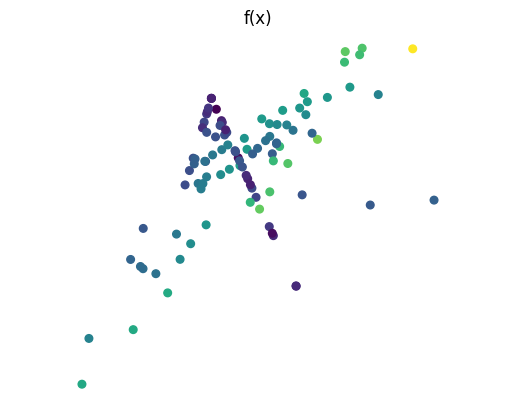

In [46]:
# create 1-layer(hidden) neural networks with ReLU activation
linear_fc_relu = nn.Sequential(nn.Linear(2,5), nn.ReLU(), nn.Linear(5,2)) # TODO
# Senquential把多个层叠加起来，当做一个子模块对待
# 第一层为线性层，第二层为ReLU层，第三层为线性层

# Visualize the output of linear_fc_relu model with random initialization
linear_fc_relu.to(device)
with torch.no_grad():
    Y = linear_fc_relu(X)
colors = X[:, 0]
show_scatterplot(Y, colors, title='f(x)')

## 3.2. Sigmoid [1 pt]
The sigmoid function is another popular choice for a non-linear activation function which maps its input to values in the interval $(0,1)$. It is formally defined as:

$$\sigma(x) = \frac{1}{1+ exp[-x]}$$

Define a new neural network `linear_fc_sigmoid` which is the same architecture as in part `3.1.` but with a sigmoid unit instead of ReLU. 

Using the same $X$ as in part `3.1`, visualize the output of passing `X` through the neural network `linear_fc_sigmoid`.

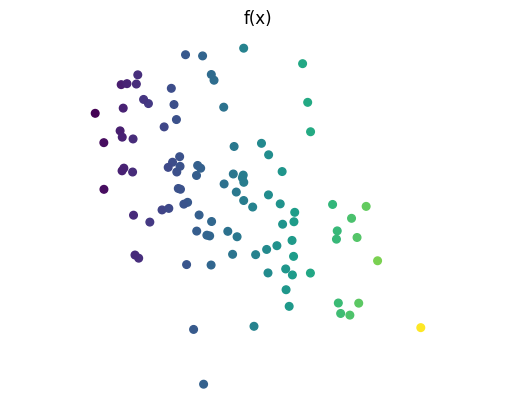

In [47]:
# create 1-layer neural networks with Sigmoid activation
linear_fc_sigmoid = nn.Sequential(nn.Linear(2,5), nn.Sigmoid(), nn.Linear(5,2)) # TODO
# 第一层为线性层，第二层为Sigmoid，第三层线性层

# Visualize the output of linear_fc_sigmoid model with random initialization
linear_fc_sigmoid.to(device)
with torch.no_grad():
    Y = linear_fc_sigmoid(X)
colors = X[:, 0]
show_scatterplot(Y, colors, title='f(x)')

# 4. Pipeline [4 pts]

In this section, we will explore some linear classifiers with different layer numbers and learn how to build a pipeline of training. 

In [38]:
# Define data generating functions
def quadratic_data_generator(data_size):
    # generate an input tensor of size data_size with torch.randn
    x = torch.randn(data_size, 1) - 2   
    x = x.to(device)

    # calculate y = x^2 + 4x - 3
    y = x * x + 4 * x - 3   # TODO
    x = x.cpu()             # 结果传回CPU
    y = y.cpu()             # 结果传回CPU
    return x, y

def cubic_data_generator(data_size=100):
    # f(x) = y = x^3 + 4x^2 - 3
    # generate an input tensor of size data_size with torch.randn
    x = torch.randn(data_size, 1) - 2   
    x = x.to(device)
    
    # calculate y = x^3 + 4x^2 - 3
    y = x * x * x + 4 * x * x - 3 # TODO
    x = x.cpu()
    y = y.cpu()
    return x, y

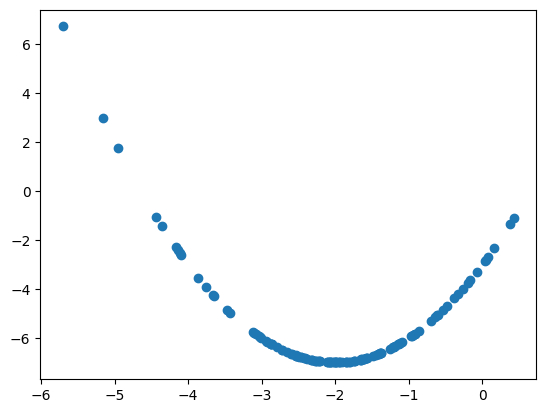

In [39]:
# Generate the data with 128 datapoints
x, y = quadratic_data_generator(128)
plt.scatter(x,y)
plt.show()

In [48]:
# Define a Linear Classifier with a single linear layer and no non-linearity
# (no hidden layer)
class Linear_0H(nn.Module):
    def __init__(self):
        super().__init__()

        self.classifier = nn.Linear(1,1)        # TODO

    def forward(self, x):
        return self.classifier(x)

In [ ]:
# Define a Linear Classifier with a single hidden layer of size 5 and ReLU non-linearity
class Linear_1H(nn.Module):
    def __init__(self):
        super().__init__()

        self.classifier = nn.Sequential(nn.Linear(1,5), nn.ReLU(), nn.Linear(5,1))      # TODO

    def forward(self, x):
        return self.classifier(x)

In [ ]:
# Define a Linear Classifier with a two hidden layers of size 5 and ReLU non-linearity
class Linear_2H(nn.Module):
    def __init__(self):
        super().__init__()

        self.classifier = nn.Sequential(nn.Linear(1,5), nn.ReLU(), nn.Linear(5,5), nn.ReLU(), nn.Linear(5,1))   # TODO

    def forward(self, x):
        return self.classifier(x)

In [ ]:
'''
TODO: Training function

Hint: look at some example pytorch tutorials to learn how to
    - initialize optimizers
    - zero gradient
    - backprop the loss
    - step the gradient


Note: This is full batch. We compute forward on whole x, y.
No need for dataloaders nor loop over batches. 
Just pass all of x to model's forward pass.
'''
def train(model, epochs, x, y):

    # Send model to device
    model = model.to(device)                # TODO

    # Set model to training mode
    model.train()
    
    # Define MSE loss function
    criterion = nn.MSELoss()                # TODO
    
    # TODO: Define the SGD optimizer with learning rate 0.01
    optimizer =  nn.optim.SGD(lr=0.01)      # TODO
    
    for epoch in range(epochs):
        
        # TODO: Forward data through model to predict y
        y_pred = model(x)                   # TODO
        
        # TODO: Compute loss in terms of predicted and true y
        loss = criterion(y, y_pred)         # TODO

        # TODO: Zero gradient
        
        # TODO: call backward on loss

        # TODO: step the optimizer
        
        # every 500 epochs, print
        if (epoch+1) % 500 == 0:
            print('Epoch {} loss: {}'.format(epoch+1, loss.item()))
            
    # return y_pred without gradient information, for plotting
    return y_pred.detach()

The code below is to visualize the prediction. You may get different curves by running multiple times because of random initialization.

In [ ]:
# 0H model on quadratic data
model = Linear_0H()
y_pred = train(model, epochs=5000, x=x, y=y)

# Plot predictions vs actual data
plt.scatter(x.cpu(), y.cpu())
plt.scatter(x.cpu(), y_pred.cpu())
plt.show()

In [ ]:
# 1H model on quadratic data
model = Linear_1H()
y_pred = train(model, epochs=5000, x=x, y=y)
plt.scatter(x.cpu(), y.cpu())
plt.scatter(x.cpu(), y_pred.cpu())
plt.show()

In [ ]:
# 2H model on quadratic data
model = Linear_2H()
y_pred = train(model, epochs=5000, x=x, y=y)
plt.scatter(x.cpu(), y.cpu())
plt.scatter(x.cpu(), y_pred.cpu())
plt.show()

In [ ]:
# Generate cubic data with 128 data points
x, y = cubic_data_generator(128)

In [ ]:
# 0H model on cubic data
model = Linear_0H()
y_pred = train(model, epochs=5000, x=x, y=y)
plt.scatter(x.cpu(), y.cpu())
plt.scatter(x.cpu(), y_pred.cpu())
plt.show()

In [ ]:
# 1H model on cubic data
model = Linear_1H()
y_pred = train(model, epochs=5000, x=x, y=y)
plt.scatter(x.cpu(), y.cpu())
plt.scatter(x.cpu(), y_pred.cpu())
plt.show()

In [ ]:
# 2H model on cubic data
model = Linear_2H()
y_pred = train(model, epochs=5000, x=x, y=y)
plt.scatter(x.cpu(), y.cpu())
plt.scatter(x.cpu(), y_pred.cpu())
plt.show()